In [18]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras.utils.vis_utils import plot_model
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

In [28]:
import pydot
print pydot.find_graphviz()



{'twopi': '/usr/bin/twopi', 'fdp': '/usr/bin/fdp', 'circo': '/usr/bin/circo', 'neato': '/usr/bin/neato', 'dot': '/usr/bin/dot', 'sfdp': '/usr/bin/sfdp'}


In [29]:
# model_path = os.path.join('..', 'snapshots', 'resnet50_csv_14.h5')
model_path = '/notebooks/keras-retinanet/snapshot/resnet18_csv_50.h5'
model_path
model = keras.models.load_model(model_path, custom_objects=custom_objects)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [4]:
labels_to_names = {0: 'peakpoint',1:'underetina',2:'vessel'}


('processing time: ', 0.5178189277648926)
[ 48 106  73 164]


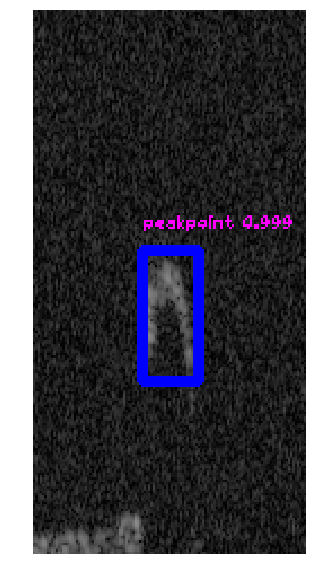

In [6]:
# load image
im = '/notebooks/cropped/5201/peakpoint/037.bmp'
image = read_image_bgr(im)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
# print ("PL:",predicted_labels)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
# print ("scores:",scores)

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    print b
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 0.5,(255, 0, 255),1)
    
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [7]:
from collections import namedtuple
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [ ]:
# image = cv2.imread(detection.image_path)
gt =[46,105,73,167]
cv2.rectangle(image,(46,105),(73,167), (0, 255, 0), 2)
cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
 
	# compute the intersection over union and display it
iou = bb_intersection_over_union(gt,b)
cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
print("{}: {:.4f}".format(im, iou))
 
	# show the output image
plt.imshow(image)


In [13]:
from keras_retinanet.utils.convnet_drawer import Model, Conv2D, MaxPooling2D, Flatten, Dense

In [14]:

def get_dense_obj(class_object, config):
    units = config.get("units", False)
    return class_object(units)


def get_maxpooling2d_obj(class_object, config):
    pool_size = config.get("pool_size", False)
    strides = config.get("strides", False)
    padding = config.get("padding", False)
    return class_object(pool_size, strides, padding)


def get_conv2d_obj(class_object, config):
    filters = config.get("filters", False)
    kernel_size = config.get("kernel_size", False)
    strides = config.get("strides", False)
    padding = config.get("padding", False)
    return class_object(filters, kernel_size, strides, padding)


def is_class_object(class_name):
    return eval(class_name)


def convert_drawer_model(model):
    _input_shape = model.input_shape
    figure = Model(input_shape=_input_shape[1:])
    for config in model.get_config():
        class_name = config.get("class_name", False)
        class_config = config.get("config", False)
        if class_name and class_config:
            class_obj = is_class_object(class_name)
            if class_name == "Conv2D":
                conv_2d = get_conv2d_obj(class_obj, class_config)
                figure.add(conv_2d)
            elif class_name == "MaxPooling2D":
                max_pooling_2d = get_maxpooling2d_obj(class_obj, class_config)
                figure.add(max_pooling_2d)
            elif class_name == "Dense":
                dense = get_dense_obj(class_obj, class_config)
                figure.add(dense)
            else:
                figure.add(class_obj())
        else:
            raise ValueError

    return figure

In [16]:
f = convert_drawer_model(model)
f.save_fig("retina.svg")


AttributeError: 'str' object has no attribute 'get'